# Part 1: Alternating Least Squares for Matrix Factorization

The notebook in [part 0](http://localhost:12345/notebooks/Part%200%20-%20Singular%20Value%20Decomposition.ipynb) introduced a popular matrix factorization technique, Singular Value Decomposition (*SVD*) and showed its usefulness. This notebook will describe how matrix factorization can be used to build a recommender system via the Alternating Least Squares (*ALS*) algorithm. To build this system, the Jester dataset explored in [part 1](Part%201%20-%20The%20Jester%20Dataset.ipynb) will be used.

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import PIL
import random
import os
import sklearn.metrics
import IPython.display
import scipy

random.seed(0)
np.random.seed(0)

Load the train and test datasets created in the dataset exploration notebook.

In [2]:
train_ratings = scipy.sparse.load_npz('datasets/train.dat.npz').toarray()
test_ratings = scipy.sparse.load_npz('datasets/test.dat.npz').toarray()

num_users = train_ratings.shape[0]
num_items = train_ratings.shape[1]

print('There are {0} users and {1} items.'.format(num_users, num_items))

There are 50691 users and 150 items.


The Alternating Least Squares (*ALS*) algorithm models the user-item interaction as a pair of matricies. The algorithm makes the following assumptions:

* Each user can be represented by a small number of numerical attributes, called "latent features," or collectively, a "latent vector."
* Each item can also be represented by a small number of latent features.
* The user-item interaction can be modeled by a dot product of the user features and the item features.

For a system with K latent features, U users, and I items, the prediction can be written like this:

![als_prediction_rule](images/2/als_prediction_rule_img.png)

The interesting part of this algorithm is that it is not necessary to know the meaning of each individual feature. There is no feature engineering involved; the algorithm will figure it out based on the minimization of a loss function. For ALS, the loss function looks like this:

![als_loss_function_rule](images/2/als_loss_function_rule_img.png)

The set S represents the set of all items that have been rated. The first term represents the error of our prediction - the squared difference between the actual user rating and our prediction. The second and third terms are regularization terms that are added to prevent overfitting. They are controlled by the two parameters lambda_x, and lambda_y. These are parameters that can be tuned to improve the model performance.

When training, the goal is to minimize the loss function. The loss function is at a minimum when the derivitave is zero. To minimize the loss, the ALS algorithm takes an iterative approach. First, the optimal values for the user latent features are computed while holding the item latent features constant. Then, using the newly-computed user latent features, the optimal values for the item latent features are computed. This process continues until the values of the latent features reach an equilbrium, at which point the algorithm is said to have converged.

To determine the computation that needs to be performed at each step, it is necessary to compute the partial derivatives of the loss function. For the user features, the expression looks like this:

![als_derivative_user](images/2/als_derivative_user_img.png)

This expression can be solved for the user features. Here, the symbol Y is introduced to represent the item latent features stacked on top of each other. Y has dimensions IxK. I is the identity matrix. The final result looks like this:

![als_derivative_user_final](images/2/als_derivative_user_final_img.png)

The computation for the item features looks similar. First, the partial derivative:

![als_derivative_item](images/2/als_derivative_item_img.png)

This expression can be solved for the item features:

![als_derivative_item_final](images/2/als_derivative_item_final_img.png)

Similar to the user derivation, the symbol X is introduced to represent the user latent features stacked on top of eache other. X has dimensions UxK. 

Enough talk, time to code! Fortunately, turning these mathematical expressions into executable code is straightforward. The code for updating the latent features is in the cell block below.

In [3]:
def als_step(latent_vectors, fixed_vectors, ratings, regularization_param, step_type):
    denom_first = fixed_vectors.T.dot(fixed_vectors)
    denom_second = np.eye(denom_first.shape[0]) * regularization_param       
    
    if step_type == 'user':
        for i in range(0, latent_vectors.shape[0], 1):
            latent_vectors[i, :] = np.linalg.solve(denom_first + denom_second, ratings[i, :].dot(fixed_vectors))
    elif step_type == 'item':
        for i in range(0, latent_vectors.shape[0], 1):
            latent_vectors[i, :] = np.linalg.solve(denom_first + denom_second, ratings[:, i].dot(fixed_vectors))
            
    return latent_vectors

def training_step(user_vec, item_vec, ratings, regularization_user, regularization_item):
    user_vec = als_step(user_vec, item_vec, ratings, regularization_user, 'user')
    item_vec = als_step(item_vec, user_vec, ratings, regularization_item, 'item')
    return (user_vec, item_vec)

As detailed in the above cell, predictions are computed by computing the dot product between the user latent features and the item latent features. For convenience, a method that computes all predictions is introduced as well. 

In [4]:
def predict_one(user_vec, item_vec, user_idx, item_idx):
    return user_vec[user_idx, :].dot(item_vec[item_idx, :])
    
def predict_all(user_vec, item_vec):
    predictions = np.zeros((num_users, num_items))
    
    for u in range(0, num_users, 1):
        for b in range(0, num_items, 1):
            predictions[u, b] = predict_one(user_vec, item_vec, u, b) 
    
    return predictions

For this example, the mean absolute error will be used as our performance metric. The computation is straightforward, although care must be taken to only include the values in the error computation for which the labels are known.

In [5]:
def compute_mean_absolute_error(predicted, actual):
    labeled_elements = actual.nonzero()
    predicted = predicted[labeled_elements].flatten()
    actual = actual[labeled_elements].flatten()
    return sklearn.metrics.mean_absolute_error(actual, predicted)

With all of the boilerplate out of the way, the training loop can be written. Here, the number of latent factors, regularization parameters, number of iterations, and initialization of the user and item features are set arbitrarily. Try changing them and seeing what effect this has on the algorithm!

Note that for larger datasets or higher number of iterations, this cell may take a long time to run.

In [6]:
num_factors = 10
l1_reg_items = 0.1
l1_reg_users = 0.1
num_iterations = 20

user_vectors = np.random.normal(size=(num_users, num_factors), scale=1.0 / num_factors)
item_vectors = np.random.normal(size=(num_items, num_factors), scale=1.0 / num_factors)

history = []
for train_idx in range(0, num_iterations, 1):
    old_user_vectors = user_vectors.copy()
    old_item_vectors = item_vectors.copy()
    user_vectors, item_vectors = training_step(user_vectors, item_vectors, train_ratings, l1_reg_items, l1_reg_users)
    
    this_history = {}
    all_predictions = predict_all(user_vectors, item_vectors)
    this_history['train_mse'] = compute_mean_absolute_error(all_predictions, train_ratings)
    this_history['test_mse'] = compute_mean_absolute_error(all_predictions, test_ratings)
    this_history['diff_users'] = np.sum(np.sum(np.abs(old_user_vectors - user_vectors)))
    this_history['diff_items'] = np.sum(np.sum(np.abs(old_item_vectors - item_vectors)))
    
    history.append(this_history)

    IPython.display.clear_output()
    print('Completed training iteration {0} / {1} ({2:.2f}%)'.format(train_idx + 1, num_iterations, (train_idx + 1) * 100.0 / num_iterations))

print('Done!')

Completed training iteration 20 / 20 (100.00%)
Done!


Now that training is complete, the error can be plotted. Some interesting trends can be observed:

* The model converges pretty quickly. It takes less than five iterations to reach its final value.
* The model does not seem to overfit. Increasing the number of training iterations does not change the train set accuracy.
* The performance is quite good, considering that zero metadata has been injected into the model. Also, there has been no attempt to do any sort of data cleaning or bias compensation.

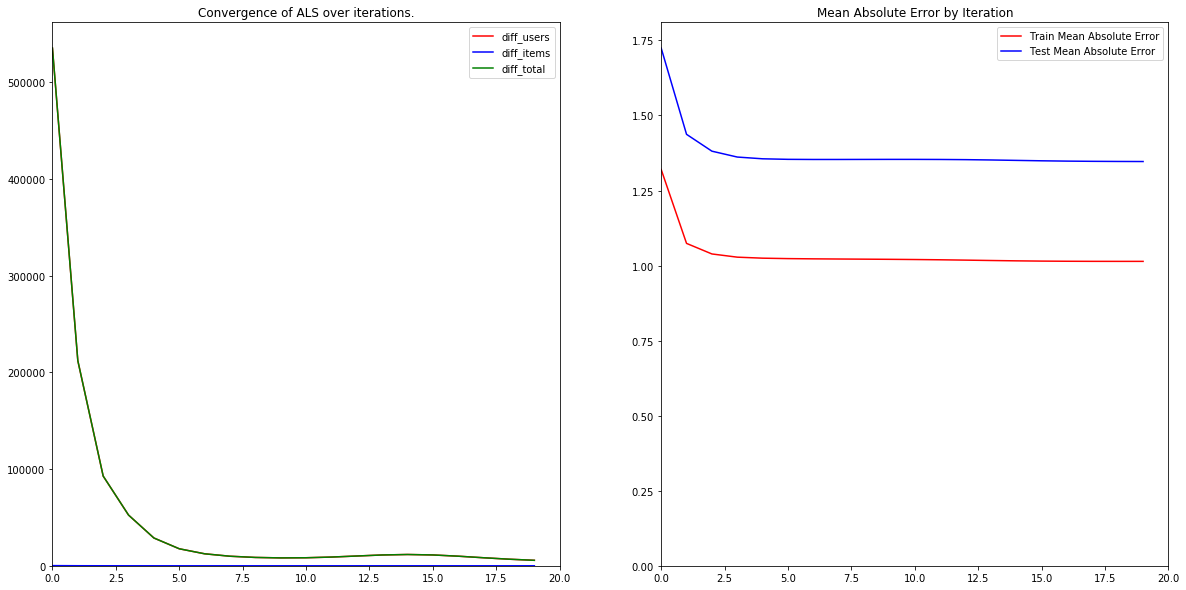

In [7]:
diff_user_vec = [h['diff_users'] for h in history]
diff_items_vec = [h['diff_items'] for h in history]
diff_total_vec = [h['diff_users'] + h['diff_items'] for h in history]
train_mse_vec = [h['train_mse'] for h in history]
test_mse_vec = [h['test_mse'] for h in history]
x_axis = list(range(0, len(history), 1))

fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

ax_left.plot(x_axis, diff_user_vec, 'r-', label='diff_users')
ax_left.plot(x_axis, diff_items_vec, 'b-', label='diff_items')
ax_left.plot(x_axis, diff_total_vec, 'g-', label='diff_total')
ax_left.set_title('Convergence of ALS over iterations.')
ax_left.set_xlim(0, max(x_axis) + 1)
ax_left.set_ylim(0, max(diff_total_vec) * 1.05)
ax_left.legend()

ax_right.plot(x_axis, train_mse_vec, 'r-', label='Train Mean Absolute Error')
ax_right.plot(x_axis, test_mse_vec, 'b-', label='Test Mean Absolute Error')
ax_right.set_title('Mean Absolute Error by Iteration')
ax_right.set_xlim(0, max(x_axis) + 1)
ax_right.set_ylim(0, max(test_mse_vec) * 1.05)
ax_right.legend()

plt.show()

We can now use the model to get the jokes that the user is most likely to appreciate. For a given user, the top 5 jokes are shown below, along with their expected rating.

In [9]:
user_id = 10
jokes_to_show = 5

jokes = pd.read_csv('datasets/jester/jester_items.tsv', sep='\t', header=None)
jokes.columns = ['joke_id', 'joke_text']
joke_ratings = []

is_labeled = [i != 0 for i in np.maximum(train_ratings[user_id, :], test_ratings[user_id, :])]

for i in range(0, jokes.shape[0], 1):
    if (not is_labeled[i]):
        joke_text = jokes.iloc[i]['joke_text']
        predicted_rating = predict_one(user_vectors, item_vectors, user_id, i)
        joke_ratings.append( (predicted_rating, joke_text) )
        
sorted_jokes = sorted(joke_ratings, reverse=True, key=lambda x: x[0])

for joke_idx in range(0, jokes_to_show, 1):
    joke = sorted_jokes[joke_idx]
    print('Joke {0} (rating {1}): {2}'.format(joke_idx + 1, joke[0], joke[1]))
    print('')

Joke 1 (rating 1.171775010975801): Early one morning a mother went to her sleeping son and woke him up. "Wake up, son. It's time to go to school." "But why, Mama? I don't want to go to school." "Give me two reasons why you don't want to go to school." "One, all the children hate me. Two, all the teachers hate me." "Oh, that's no reason. Come on, you have to go to school." "Give me two good reasons why I should go to school." "One, you are fifty-two years old. Two, you are the principal of the school."

Joke 2 (rating 1.1693442197751025): A man goes into a drug store and asks the pharmacist if he can give him something for the hiccups. The pharmacist promptly reaches out and slaps the man's face. "What the heck did you do that for?!" the man screams. "Well, you don't have the hiccups anymore, do you?" The man says, "No I don't, you IDIOT...but my wife out in the car still does!"

Joke 3 (rating 1.1355548464113538): A radio conversation between a US naval ship and Canadian authorities...

There are a few additional points to make about this algorithm
* The computation of this algorithm is embarrassingly parallel. Each user feature and item feature can be computed independently of each other. This leads to an efficient map-reduce implementation, which makes this algorithm popular for large datasets.
* While this algorithm generally does not lead the best performance, it has the attractive property of not being as prone to overfitting as other algorithms. Thus, many recommendation systems include this algorithm as one of the predictors in an ensemble model.
* When new users or items are added to the catalog, the entire model must be recomputed, which is expensive. This is a drawback for systems that need to rapidly adapt to changing datasets.